# Kernel Fourier Networks
Friday Oct 2, 2020

- filter = Tensor(3x3)
- k = FFT(filter)
- K(... params) = approx(k)

- apply pointwise multiplication of approx(k) and FFT of image.


# Data

In [4]:
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/lukewood/kernel-fourier-convolution && cd kernel-fourier-convolution && pip install .

In [5]:
import tensorflow as tf
NUM_CLASSES = 2
IMG_SIZE=(150, 150)
def makeThumb(img, size=(150,150)):
  return tf.keras.preprocessing.image.smart_resize(img, size)/255.0

import tensorflow_datasets as tfds
cats_vs_dogs = None
try:
  cats_vs_dogs = tfds.image_classification.cats_vs_dogs.CatsVsDogs()
except:
  cats_vs_dogs = tfds.image.cats_vs_dogs.CatsVsDogs()
cats_vs_dogs.download_and_prepare()
dataset = cats_vs_dogs.as_dataset(shuffle_files=False)

In [6]:
def to_numpy(ds, size=None):
  X = []
  y = []
  csize=0
  for datapoint in ds:
    if size != None and csize > size:
      return X, y
    X.append(makeThumb(datapoint['image'].numpy(), size=IMG_SIZE))
    y.append(tf.keras.utils.to_categorical(datapoint['label'].numpy(), NUM_CLASSES))
    csize+=1
  return X, y

def to_gen(X, y, batch_size=32):
  idx = 0
  while idx < len(X) and idx < len(y):
    Xs = []
    ys = []
    for _ in range(batch_size):
      if idx >= len(X) or idx >= len(y):
        break
      Xs.append(X[idx])
      ys.append(y[idx])
      idx+=1
    yield np.array(Xs), np.array(ys)

In [7]:
X, y = to_numpy(dataset['train'])

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=[0.5, 1.0],
    brightness_range=(0.85, 1.15),
    horizontal_flip=True
)

# Vis

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from kernel_fourier_convolution.layers import FourierDomainConv2D, LinearKernelFourierConvolution

def visualize_filters(model):
  real_filters = []
  imag_filters = []
  for layer in model.layers:
    if isinstance(layer, FourierDomainConv2D):
      real_kernel, imag_kernel = layer.real_kernel, layer.imag_kernel
      for i in range(6):
        real_filters.append(real_kernel[:, :, i])
        imag_filters.append(imag_kernel[:, :, i])
    elif isinstance(layer, LinearKernelFourierConvolution):
      real_kernel, imag_kernel = layer.expand_kernel(150, 76)
      for i in range(6):
        real_filters.append(real_kernel[:, :, i])
        imag_filters.append(imag_kernel[:, :, i])
        
  fig=plt.figure(figsize=(8, 8))
  columns = 6
  rows = 4
  for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    red = real_filters[i-1]
    green = np.zeros(red.shape)
    blue = imag_filters[i-1]
    img = np.stack([red, green, blue], axis=-1)
    x = img
    img = (x-np.minimum.reduce(x))/(np.maximum.reduce(x)-np.minimum.reduce(x))
    img[:, :, 1] = np.zeros(red.shape)
    plt.axis('off')
    plt.imshow(img)
  plt.show()

## Untrained Models

## Fourier conv 2D

In [25]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Flatten, Activation, Dense
from kernel_fourier_convolution.layers import FourierDomainConv2D, fft_layer, from_complex

def fourier_block(x, filters=6):
  x = FourierDomainConv2D(filters)(x)
  x = Activation('relu')(x)
  return x

def create_fourier_model(filter_blocks = [6, 6, 6, 6]):
  inputs = Input(shape=(150, 150, 3))
  x = fft_layer(inputs)
  x = from_complex(x)
  for f in filter_blocks:
    x = fourier_block(x, filters=f)
  x = Flatten()(x)
  preds = Dense(NUM_CLASSES)(x)

  model = Model(inputs=inputs, outputs=preds)
  return model

model = create_fourier_model()

### Before Training

<ipython-input-24-4f43c2852c42>:30: RuntimeWarning: invalid value encountered in true_divide
  img = (x-np.minimum.reduce(x))/(np.maximum.reduce(x)-np.minimum.reduce(x))


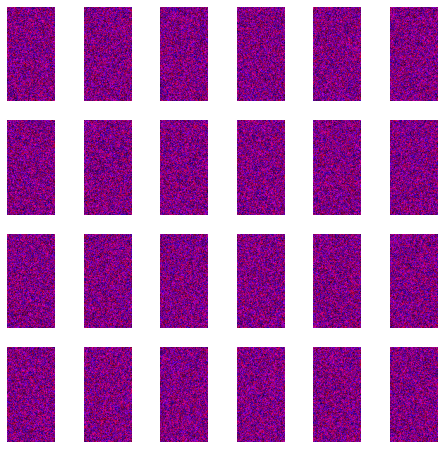

In [26]:
model = create_fourier_model()
visualize_filters(model)

### After Training

In [ ]:
import sklearn.model_selection
training_epochs=3
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33)
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
  )
X_train = np.array(X_train)
y_train = np.array(y_train)
datagen.fit(X_train)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
      steps_per_epoch=len(X_train) / 64, epochs=training_epochs)

Epoch 1/3
 46/243 [====>.........................] - ETA: 9:07 - loss: 0.2866 - accuracy: 0.5393

In [ ]:
visualize_filters(model)

## Kernel


In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Activation
from tensorflow.keras import Model
from kernel_fourier_convolution.layers import LinearKernelFourierConvolution, fft_layer, from_complex

def linear_kernel_fourier_conv_block(x, filters=6, order=1):
  x = LinearKernelFourierConvolution(filters, order=order)(x)
  x = Activation('relu')(x)
  return x

def create_linear_model(filter_blocks = [6, 6, 6, 6], order=1):
  inputs = Input(shape=(150, 150, 3))
  x = fft_layer(inputs)
  x = from_complex(x)
  for f in filter_blocks:
    x = linear_kernel_fourier_conv_block(x, filters=f, order=order)
  x = Flatten()(x)
  preds = Dense(2)(x)

  model = Model(inputs, preds)
  optimizer = tf.optimizers.Adam()
  return model
model=create_linear_model()

In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Activation
from tensorflow.keras import Model
from kernel_fourier_convolution.layers import Gaussian2DKernelFourierLayer, fft_layer, from_complex

def gaussian_block(x, filters=6, order=1):
  x = Gaussian2DKernelFourierLayer(filters)(x)
  x = Activation('relu')(x)
  return x

def create_gaussian_model(filter_blocks = [6, 6, 12, 12, 24, 24], order=1):
  inputs = Input(shape=(150, 150, 3))
  x = fft_layer(inputs)
  x = from_complex(x)
  for f in filter_blocks:
    x = gaussian_block(x, filters=f, order=order)
  x = Flatten()(x)
  preds = Dense(2)(x)

  model = Model(inputs, preds)
  optimizer = tf.optimizers.Adam()
  return model
model=create_gaussian_model()

## Linear

In [ ]:
model = create_linear_model()

In [ ]:
import sklearn.model_selection
training_epochs=3
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33)
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
  )
X_train = np.array(X_train)
y_train = np.array(y_train)
datagen.fit(X_train)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
      steps_per_epoch=len(X_train) / 64, epochs=training_epochs)

In [ ]:
visualize_filters(model)

## Gaussian

In [ ]:
model = create_gaussian_model()

In [ ]:
import sklearn.model_selection
training_epochs=3
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33)
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
  )
X_train = np.array(X_train)
y_train = np.array(y_train)
datagen.fit(X_train)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
      steps_per_epoch=len(X_train) / 64, epochs=training_epochs)

In [ ]:
visualize_filters(model)